In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
# from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob
import difflib


In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
def match_kana(text) : 
    match_kana = [] 
    kana_text = ["あ","い","う","え","か","き","く","け","こ","を" , "さ","す","せ","そ","た-と","な-の","は","ひ","ふ","ほ","ま-も","や","ゆ","ら","り","る"]
    for x in kana_text:
        sequence = difflib.SequenceMatcher(isjunk=None, a=x, b=text)
        difference = sequence.ratio()
        match_kana.append(difference)
    confidence = max(match_kana)
    print(f" Kana matching confidence: {confidence}")
    a = match_kana.index(confidence)
    kana_name = kana_text[a]
    return kana_name if confidence else ""

In [4]:

def match_org(text, org_type):
    match_value = []
    if org_type == "ja":
        places_name = [
            "静岡",
            "福岡",
            "福島",
            "岐阜",
            "群馬",
            "広島",
            "金沢",
            "北見",
            "高知",
            "新潟市",
            "帯広",
            "大分",
            "徳島",
            "富山",
            "宇都宮",
            "岡山",
            "札幌",
            "仙台",
            "沼津",
            "千葉",
            "山梨",
            "多摩",
            "大阪",
            "横浜",
            "前橋",
            "練馬",
            "和歌山",
            "神戸" , 
            "宮崎", 
            "埼玉",
            "熊谷",
            "品川",
            "奈良",
            "足立" , 
            "京都",
            "なにわ" , 
            "姫路" ,
            "川崎",
            "野田",
            "長野"
        ]
    for x in places_name:
        sequence = difflib.SequenceMatcher(isjunk=None, a=x, b=text)
        difference = sequence.ratio()
        match_value.append(difference)
    confidence = max(match_value)
    print(f"{org_type} Org matching confidence: {confidence}")
    a = match_value.index(confidence)
    organization_name = places_name[a]
    return organization_name if confidence else ""

In [5]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [6]:

class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    print(final_labels_frontal[0].wh())
    print((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]))
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.46) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor


def detect_lp(model, I, max_dim, lp_threshold):
    print(f"I.shape {I.shape}")
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img 
    print("Factor",factor)
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor ).astype(int).tolist()
    print(f"w,h {w}, {h}")
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    print("COr",Cor)
    return L, TLp, lp_type, Cor



Ration  1.165016501650165
708
608
I.shape (706, 606, 3)
Factor 1.0033003300330032
w,h 608, 708
[0.23670933 0.10855454]
2.1805566520422133
COr [array([[380.70224544, 524.14809826, 563.91725601, 420.4714032 ],
       [356.58920036, 317.82357834, 394.4630848 , 433.22870682],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]
Cor [array([[380.70224544, 524.14809826, 563.91725601, 420.4714032 ],
       [356.58920036, 317.82357834, 394.4630848 , 433.22870682],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]
[[380.70224544 524.14809826 563.91725601 420.4714032 ]
 [356.58920036 317.82357834 394.4630848  433.22870682]
 [  1.           1.           1.           1.        ]]
LPT IMG  [[[0.07991728 0.15602788 0.14659926]
  [0.08235294 0.15882353 0.14901961]
  [0.08275123 0.16165748 0.1495098 ]
  ...
  [0.59118413 0.55363051 0.62113971]
  [0.59007353 0.53762255 0.61286765]
  [0.5861826  0.52490809 0.60346201]]

 [[0.09881281 0.16440717 0.18056832]
  [0.09609375 0.

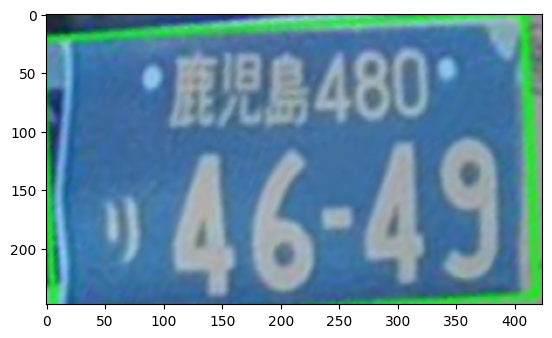

In [7]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2]) 
    print("Ration ",ratio)
    side = int(ratio * Dmin)
    print(side)
    bound_dim = min(side, Dmax) 
    print(bound_dim)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    print("Cor",cor)
    return vehicle, LpImg, cor
test_image_path = "Plate_examples/real_test01.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)
print(cor[0])
print("LPT IMG ", LpImg[0])
# fig = plt.figure(figsize=(12,6)
# grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# fig.add_subplot(grid[0])
# plt.axis(False)
# plt.imshow(vehicle)
# grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
# fig.add_subplot(grid[1])
# plt.axis(False)
LpImg[0] = cv2.resize(LpImg[0], (424,248))
plt.imshow(LpImg[0])

In [8]:
import numpy as np
from PIL import Image

# Create a numpy array from your data
data = np.array(LpImg[0])

# Multiply by 255 to convert to 8-bit values
data = (data * 255).astype(np.uint8)

# Create a PIL image from the numpy array
img = Image.fromarray(data)

# Save the image as a file
img.save('testing123.png')

In [9]:
import easyocr

# Initialize the EasyOCR reader
reader = easyocr.Reader([ 'ja',],recog_network='japanese_g2',)

# Load the image
# Perform OCR on the image
result = reader.readtext('testing123.png',paragraph=False,detail = 0)
print(result)

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


["鹿児島480'", 'り', '4649']


Testing with Image Segmentation

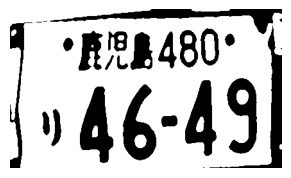

In [10]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

# for i in range(len(plot_image)):
#     fig.add_subplot(grid[i])
#     plt.axis(False)
#     plt.title(plot_name[i])
#     if i ==0:
#         plt.imshow(plot_image[i])
#     elif i == 3  :
#         plt.imshow(plot_image[i],cmap="gray")
#         fig.savefig('testing123.png')
#     else:
#         plt.imshow(plot_image[i],cmap="gray")
fig.add_subplot(grid[3])
plt.axis(False)
plt.imshow(plot_image[4],cmap="gray")
fig.savefig('imageSEG.png')
# plt.savefig("threshding.png", dpi=300)
# plt.imshow(plot_image[2])

In [11]:
import easyocr

# Initialize the EasyOCR reader
reader3 = easyocr.Reader(['ja'],recog_network='japanese_g2',)

# Load the image
# Perform OCR on the image
result3 = reader3.readtext('imageSEG.png',paragraph=False,detail = 0)
print(result3)

["・良児島480'", '46*49']


In [12]:
import easyocr

# Initialize the EasyOCR reader
reader2 = easyocr.Reader(['ja','en'],recog_network='japanese_g2',)

# Load the image
# Perform OCR on the image
result2 = reader2.readtext('imageSEG.png',paragraph=False,detail = 0)
print(result2)

["・良児島480'", '46*49']


In [13]:
print(result)
print(result3) 
print(result2)

["鹿児島480'", 'り', '4649']
["・良児島480'", '46*49']
["・良児島480'", '46*49']


In [14]:
kana_text = ["あ","い","う","え","か","き","く","け","こ","を" , "さ","す","せ","そ","た-と","な-の","は","ひ","ふ","ほ","ま-も","や","ゆ","ら","り","る"]
kana_result = ""
detected = False
print("Detected Result",result2[1])
if len(result2) == 2:
    for i in kana_text:
        if i in result2[1]:
            detected = True
            kana_result = i 
            result2[1] = result2[1].replace(i, "")
            break
    if detected == False:
        print("No match in list so need to predict")
        match_result = match_kana(result2[1])
        print(match_result)
        kana_result = match_result[0]
elif len(result2) == 3 : 
    for i in kana_text:
        if i in result2[1]:
            kana_result = i 
            result2[2] = result2[2].replace(i, "")
            break
        else : 
            print("No match in list so need to predict")
            match_result = match_kana(result2[2])
            kana_result = match_result[0]
print(kana_result)
print(result2[1])


Detected Result 46*49
No match in list so need to predict
 Kana matching confidence: 0.0



IndexError: string index out of range

In [ ]:
match1 = match_org(result2[0],'ja')
# result2[0].replace(match1,"")
if(match1 in result2[0]):
    result2[0] = result2[0].replace(match1,"")
print("PREDICTED KANA",kana_result)
print("PREDICTED PLACES",match1) 
print("PREDICTED NUMBERS",result2[1])
print("PREDICTED CLASSIFICATION NUM",result2[0])

ja Org matching confidence: 0.4
PREDICTED KANA た
PREDICTED PLACES 静岡
PREDICTED NUMBERS *-23
PREDICTED CLASSIFICATION NUM 静5に
